# Altana Machine Learning Project

## Overview

For this machine learning project, the problem statement is to predict .

I break this task down into several steps:

1. Setting up the project structure
2. Analyzing the provided data set
3. Training models and analyzing output
4. Building and testing a microservice to provide the models

## Project setup

My first step in a machine learning project is to start with a standard project format for organizing data, code, analysis, and results.  My current company has its own standard project platform, which splits tasks into data acquisition, preprocessing, model training, and evaluation.  I would normally be splitting the task into data analysis, data preparation, model training, evaluation, and deployment but have collapsed this due to time.

I uploaded the training data file provided for the interview project to a raw_data directory.  This is the location for the original, immutable data.  This notebook is hosted on Amazon Sagemaker.

## Data exploration

The first action I take is to load the dataset using pandas and read_csv.  I want to see the structure of the data file and look at the range of the data values, see if the are empty fields, and understand before creating the system.

In [ ]:
# Default Sagemaker pandas is not the latest
!pip install -U pandas

In [2]:
import pandas as pd

shipment_df = pd.read_csv("data/raw/ds-project-train.csv") 

print(f"Rows: {shipment_df.shape[0]}")
print(f"Columns: {shipment_df.shape[1]}")

print(shipment_df.info())
print(shipment_df.head(2))

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Rows: 143280
Columns: 30
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143280 entries, 0 to 143279
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          143280 non-null  int64  
 1   SHIPPER             122415 non-null  object 
 2   SHIPPER.ADDRESS     30957 non-null   object 
 3   CONSIGNEE           131693 non-null  object 
 4   CONSIGNEE.ADDRESS   32756 non-null   object 
 5   ZIPCODE             120907 non-null  object 
 6   NOTIFY              117088 non-null  object 
 7   NOTIFY.ADDRESS      114624 non-null  object 
 8   BILL.OF.LADING      131693 non-null  object 
 9   ARRIVAL.DATE        131693 non-null  object 
 10  WEIGHT..LB.         131693 non-null  float64
 11  WEIGHT..KG.         131693 non-null  float64
 12  US.PORT             131187 non-null  object 
 13  QUANTITY            131693 non-null  float64
 14  Q.UNIT              130923 non-null  object 
 15  MEASUREME

There are 143,280 training rows.  The project specifies to limit the source features to the WEIGHT..KG., ARRIVAL.DATE, US.PORT and possibly PRODUCT.DETAILS to predict the COUNTRY.OF.ORIGIN.

Next I check the quality of the data and I look at counts for each label.

In [3]:
import numpy as np
# Check if any empty values in source or target columns
print(shipment_df['WEIGHT..KG.'].isnull().value_counts())
# Check for NaNs, infinites in weight
print(np.any(np.isnan(shipment_df['WEIGHT..KG.'])))
print(np.all(np.isfinite(shipment_df['WEIGHT..KG.'])))
shipment_df['WEIGHT..KG.'] = shipment_df['WEIGHT..KG.'].fillna(0)
print(np.any(np.isnan(shipment_df['WEIGHT..KG.'])))

print(shipment_df['ARRIVAL.DATE'].isnull().value_counts())
print(shipment_df['US.PORT'].isnull().value_counts())
print(shipment_df['PRODUCT.DETAILS'].isnull().value_counts())
print(shipment_df['COUNTRY.OF.ORIGIN'].isnull().value_counts())

False    131693
True      11587
Name: WEIGHT..KG., dtype: int64
True
False
False
False    131693
True      11587
Name: ARRIVAL.DATE, dtype: int64
False    131187
True      12093
Name: US.PORT, dtype: int64
False    131618
True      11662
Name: PRODUCT.DETAILS, dtype: int64
False    130485
True      12795
Name: COUNTRY.OF.ORIGIN, dtype: int64


It looks like 11,587 of the rows are valueless.  US.PORT, PRODUCT.DETAILS and COUNTRY.OF.ORIGIN have additional empty values.  I'll filter out all the rows with empty COUNTRY.OF.ORIGIN and check again.  An alternative to this would be to predict if the country of origin was unknown.  Since I don't know why the country would be unspecified I'm going to assume these are data errors and remove them but would be happy to adjust if needed.

In [4]:
# Remove rows with empty country of origin
shipment_df.dropna(subset=['COUNTRY.OF.ORIGIN'], inplace=True)
print(shipment_df['WEIGHT..KG.'].isnull().value_counts())
print(shipment_df['ARRIVAL.DATE'].isnull().value_counts())
print(shipment_df['US.PORT'].isnull().value_counts())
print(shipment_df['PRODUCT.DETAILS'].isnull().value_counts())
print(shipment_df['COUNTRY.OF.ORIGIN'].isnull().value_counts())

# Replace empty US.PORT with "UNKNOWN"
shipment_df['US.PORT'] = shipment_df['US.PORT'].fillna('UNKNOWN')
print(shipment_df['US.PORT'].isnull().value_counts())

# Here I'm also mapping the ARRIVAL DATE to the internal pandas DateTime format
shipment_df['ARRIVAL.DATE.PROCESSED']= pd.to_datetime(shipment_df['ARRIVAL.DATE'])


False    130485
Name: WEIGHT..KG., dtype: int64
False    130485
Name: ARRIVAL.DATE, dtype: int64
False    130485
Name: US.PORT, dtype: int64
False    130410
True         75
Name: PRODUCT.DETAILS, dtype: int64
False    130485
Name: COUNTRY.OF.ORIGIN, dtype: int64
False    130485
Name: US.PORT, dtype: int64


This removes all the empty values except for a few US.PORT.  For these, the null value is replaced by an "UNKNOWN" string that can be used as a feature.  I write out the cleaned file to separate "processed" data directory.

In [5]:
# Also checking on the test data null country values, making sure to keep it blind
shipment_test_df = pd.read_csv("data/raw/ds-project-validation.csv") 
print(shipment_test_df['COUNTRY.OF.ORIGIN'].isnull().value_counts())

False    43608
True      4152
Name: COUNTRY.OF.ORIGIN, dtype: int64


In testing I'll ignore these rows, though it would also be possible to replace the empty country with "UNKNOWN".

                    COUNTRY.OF.ORIGIN
China                           94041
Hong Kong                        4934
South Korea                      4271
Singapore                        4147
Oman                             2345
Panama                           2298
China Taiwan                     2192
Malaysia                         2061
Guatemala                        1659
Spain                            1374
Costa Rica                       1272
India                            1202
Japan                             835
Chile                             776
Sri Lanka                         743
Pakistan                          670
Germany                           643
Thailand                          616
Vietnam                           527
Mexico                            389
Italy                             354
Brazil                            289
Egypt                             287
American Samoa                    252
Bahamas                           250
Honduras    

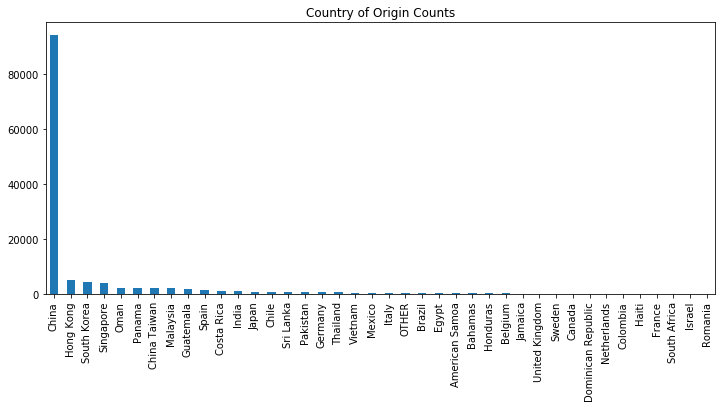

In [6]:
import matplotlib.pyplot as plt

country_counts = pd.DataFrame(shipment_df['COUNTRY.OF.ORIGIN'].value_counts())
print(country_counts[country_counts['COUNTRY.OF.ORIGIN'] > 50])

common_countries = set(country_counts[country_counts['COUNTRY.OF.ORIGIN'] > 50].index)
shipment_df['COUNTRY.OF.ORIGIN.MAPPED'] = shipment_df['COUNTRY.OF.ORIGIN'].apply(
    lambda x: 'OTHER' if x not in common_countries else x)

shipment_df['COUNTRY.OF.ORIGIN.MAPPED'].value_counts().plot.bar(title='Country of Origin Counts', figsize=(12,5))

The values to predict are highly imbalanced, with "China" far and away the most frequent country of origin, with a big jump down to "Hong Kong", "South Korea", etc. and finally a long tail of countries with only one occurance.  I also see some possibilities for normalization, with "Federal Republic of Germany" and "Germany" occurring.

I'll need to consider this when building a model and look at the per country precision/recall scores to get metrics.  Just guessing "China" would give deceptively high accuracy scores.  The countries with single digit counts will also be hard to predict at all.  Here I take the instructions' suggestion and replace countries occurring less than 50 times with "OTHER".  The best number to use for the cut off would require some experiments.

For a check on the quality of the data, I look at how many duplicate data points occur, starting with the three recommended input columns.

Long Beach, California                              31594
Norfolk, Virginia                                   21704
Savannah, Georgia                                   19514
Los Angeles, California                             19301
Houston, Texas                                      16341
Seattle, Washington                                  8753
New York/Newark Area, Newark, New Jersey             2760
Tacoma, Washington                                   2491
Charleston, South Carolina                           2286
Miami, Florida                                       1301
Oakland, California                                   978
Philadelphia, Pennsylvania                            701
San Juan, Puerto Rico                                 601
New York, New York                                    562
New Orleans, Louisiana                                375
Port Everglades, Florida                              335
Jacksonville, Florida                                 257
Baltimore, Mar

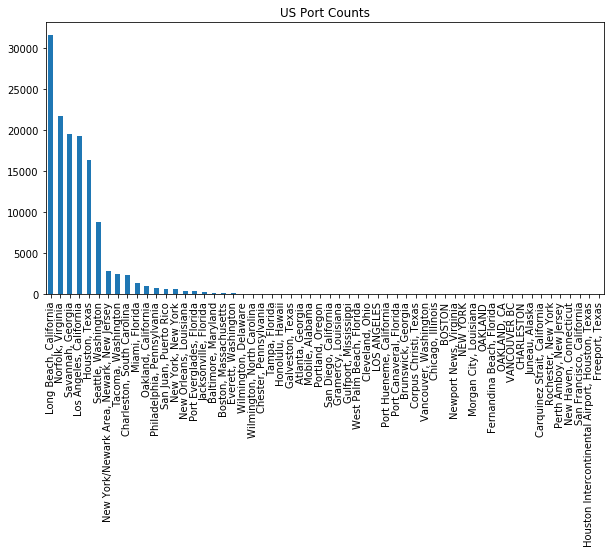

In [7]:
# US Port counts
print(shipment_df['US.PORT'].value_counts())

shipment_df['US.PORT'].value_counts().plot.bar(title='US Port Counts', figsize=(10,5))

The distribution here is also highly imbalanced.  

I can see some normalization would help.  For example, mapping "OAKLAND, CA" to "Oakland, California".  I would do that in a production system, but due to the limited time for the project and the fact the duplicate counts here are small enough, I'm going to forgo it here.  Other interesting feature experiments could be to group ports in different ways, such as by West or East or Gulf coast or Northern vs. Southern, which might help the low count ports contribute to the final model.

In [8]:
# Check on the arrival dates
print(f"Earliest date: {shipment_df['ARRIVAL.DATE.PROCESSED'].min()}")
print(f"Latest date  : {shipment_df['ARRIVAL.DATE.PROCESSED'].max()}")

print(f"Unique days: {len(shipment_df['ARRIVAL.DATE'].unique())}")

Earliest date: 2012-09-17 00:00:00
Latest date  : 2013-09-09 00:00:00
Unique days: 357


The training covers about a year's worth of data.  Let's look at the distribution: 

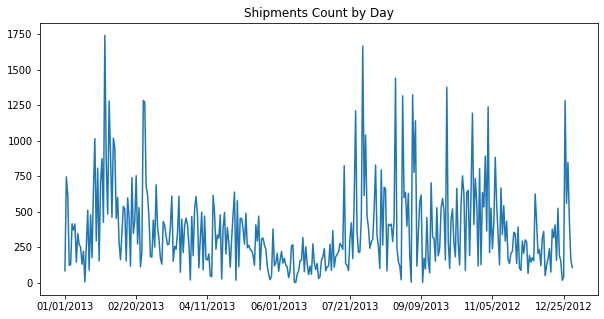

In [9]:
shipment_df['ARRIVAL.DATE'].value_counts().sort_index().plot(title="Shipments Count by Day", figsize=(10,5))

The shipments per date have a lot of variation, with some periods quite high and others low.  Since the date itself would not be useful for predicting future shipments, other possibilities include using the day (or week) of the month, the month, the day of the week, or the season of the year.

Next, look at the weight distribution:

0.0
60500000.0


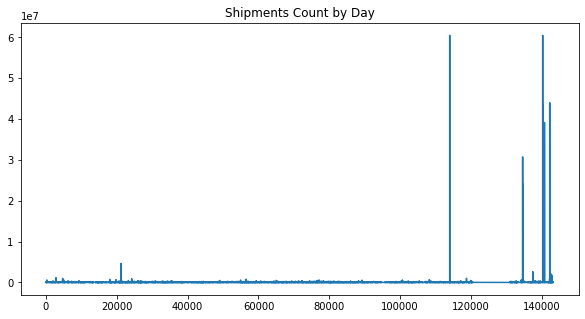

In [10]:
print(shipment_df['WEIGHT..KG.'].min())
print(shipment_df['WEIGHT..KG.'].max())

shipment_df['WEIGHT..KG.'].plot(title="Shipments Count by Day", figsize=(10,5))

The weights are mostly evenly distributed except for a few huge outliers.  It will need some scaling.  There is also a huge range, from 0 to 60 million kg.

In [11]:
for country in shipment_df['COUNTRY.OF.ORIGIN'].unique():
    original_size = shipment_df[shipment_df['COUNTRY.OF.ORIGIN'] == country].shape[0]
    if original_size == 0:
        continue
    no_duplicates_size = shipment_df[shipment_df['COUNTRY.OF.ORIGIN'] == country].drop_duplicates(['WEIGHT..KG.', 'ARRIVAL.DATE', 'US.PORT']).shape[0]
    print(f"Label: {country:>30}\tOriginal size: {original_size}\tAfter removing duplicates (3 features): {no_duplicates_size}\t"
          f"Duplicates: {original_size-no_duplicates_size}\t"
          f"{100*((original_size-no_duplicates_size)/original_size):0.1f}%"
         )
    no_duplicates_size = shipment_df[shipment_df['COUNTRY.OF.ORIGIN'] == country].drop_duplicates(['WEIGHT..KG.', 'ARRIVAL.DATE', 'US.PORT', 'PRODUCT.DETAILS']).shape[0]
    print(f"Label: {country:>30}\tOriginal size: {original_size}\tAfter removing duplicates (4 features): {no_duplicates_size}\t"
          f"Duplicates: {original_size-no_duplicates_size}\t"
          f"{100*((original_size-no_duplicates_size)/original_size):0.1f}%"
         )

Label:                          China	Original size: 94041	After removing duplicates (3 features): 87475	Duplicates: 6566	7.0%
Label:                          China	Original size: 94041	After removing duplicates (4 features): 93207	Duplicates: 834	0.9%
Label:                      Hong Kong	Original size: 4934	After removing duplicates (3 features): 4522	Duplicates: 412	8.4%
Label:                      Hong Kong	Original size: 4934	After removing duplicates (4 features): 4830	Duplicates: 104	2.1%
Label:                          Egypt	Original size: 287	After removing duplicates (3 features): 274	Duplicates: 13	4.5%
Label:                          Egypt	Original size: 287	After removing duplicates (4 features): 287	Duplicates: 0	0.0%
Label:                          India	Original size: 1202	After removing duplicates (3 features): 1181	Duplicates: 21	1.7%
Label:                          India	Original size: 1202	After removing duplicates (4 features): 1192	Duplicates: 10	0.8%
Label:      

Several of the countries have significant duplication per country when restricted to the recommended three input columns.  For example, 7% for China and 8.4% for Hong Kong, ranging from a max of 49.5% for Guatemala to no duplicates for many low volume countries.

Using just these three features would possibly skew the experiments.  Expanding the input feature set to include the product description lowers the duplicate percentages considerably but duplicates still occur.

I also check on labeling consistency below, looking for features sets that are the same but are marked as two or more different countries.  In this case, given the numbers below, these happen relatively rarely.  That should not cause any problems.

In [12]:
from collections import Counter, defaultdict

country_counts = defaultdict(Counter)

for index, row in enumerate(shipment_df[['WEIGHT..KG.', 'ARRIVAL.DATE', 'US.PORT', 'COUNTRY.OF.ORIGIN']].itertuples()):
    country_counts[f"{row[1]} {row[2]} {row[3]}"][row[-1]] += 1

multiple_labels = [text for text in country_counts if len(country_counts[text]) > 1]
print(f"Inconsistently labeled shipment count: {len(multiple_labels)}\n")
for text in sorted(multiple_labels, key=lambda x: sum(country_counts[x][y] for y in country_counts[x]), reverse=True)[:20]:
    print(f"{text}:\t{country_counts[text]}")

Inconsistently labeled shipment count: 298

3.0 07/29/2013 Savannah, Georgia:	Counter({'China Taiwan': 11, 'China': 2})
5.0 02/25/2013 Long Beach, California:	Counter({'China': 9, 'China Taiwan': 1})
23.0 07/30/2013 Norfolk, Virginia:	Counter({'Hong Kong': 8, 'China': 1})
6.0 07/29/2013 Savannah, Georgia:	Counter({'China': 6, 'China Taiwan': 2})
7.0 07/29/2013 Savannah, Georgia:	Counter({'China Taiwan': 5, 'China': 3})
2.0 07/29/2013 Savannah, Georgia:	Counter({'China Taiwan': 5, 'China': 3})
19.0 07/30/2013 Norfolk, Virginia:	Counter({'Hong Kong': 6, 'China': 2})
17388.0 07/22/2013 New York/Newark Area, Newark, New Jersey:	Counter({'Chile': 6, 'Panama': 1})
35.0 01/30/2013 Savannah, Georgia:	Counter({'South Korea': 4, 'China': 3})
15.0 02/01/2013 Savannah, Georgia:	Counter({'China Taiwan': 5, 'Panama': 2})
43279.5 02/13/2013 Houston, Texas:	Counter({'Colombia': 4, 'Panama': 3})
9.1 01/21/2013 Los Angeles, California:	Counter({'China': 5, 'Vietnam': 1})
27.0 01/30/2013 Savannah, Georgi

## Split the data

I was provided with a training and validation set.  Good ML practice is to keep the final evaluation set blind so it is useful to have a development set to run development tests with.  Even though due to time I didn't end up using a dev set for this project, I still illustrate how I would create it below.  I split the training set into train/dev using the sklearn train_test_split method, using stratify to keep the country ratios comparable between the two sets.  I use the default 75/25 split.  An alternative to this is to use cross-validation and average the n-fold scores.

In [16]:
# Split into train/test 
from sklearn.model_selection import train_test_split

train_df, dev_df = train_test_split(shipment_df, random_state=0, stratify=shipment_df['COUNTRY.OF.ORIGIN.MAPPED'])

print(f"Train size: {train_df.shape[0]}")
train_df.head()
train_df.to_pickle("data/processed/train.pkl")

print(f"Dev size: {dev_df.shape[0]}")
dev_df.to_pickle("data/processed/dev.pkl")

Train size: 97863
Dev size: 32622


## Training

I used sklearn to featurize the data and train the model.  I've included the training script training.py which uses python 3.6.  Also included are a requirements file.

> pip install -r requirements.txt

I did all my work using SageMaker studio.  I didn't take advantage of its training and endpoint building for this project though they are handy for larger datasets and for ease of deployment.  SageMaker is especially useful when training neural networks for its access to GPU machines for only as long as needed.

## Conclusions

In the above project, my goal was to create a topic classifier.  As part of this I:

1.  Analyzed the provided training data

   For the data set, I looked for empty values, duplicate entries, and similar shipments with different countries.  I investigate data distributions and how some input features would need to be adjusted to be useful for classification
   
2.  Trained a classification model

   I built a pipeline to take in the raw CSV files, clean missing values, preprocess and then use that for either training or inference.  I separated out common code into separate classes and used a defined division between stages to make maintenance and future work easier, both for myself and anybody else who would work on it.  I also added functionality for model versioning and to upload models to the cloud.  If building a web service to productionalize the model, the cloud service could download the model (based on a configuration) and serve it.
   
   Final scores on the validation set:

Classification report

        American Samoa       1.00      1.00      1.00        84
               Bahamas       0.52      0.81      0.63        97
               Belgium       0.57      0.79      0.67        63
                Brazil       0.69      0.91      0.78        86
                Canada       0.26      0.84      0.40        43
                 Chile       0.95      0.97      0.96       267
                 China       0.99      0.82      0.90     31325
          China Taiwan       0.45      0.90      0.60       764
              Colombia       0.61      0.81      0.69        42
            Costa Rica       0.97      1.00      0.98       444
    Dominican Republic       0.69      0.78      0.73        37
                 Egypt       0.88      0.99      0.93        81
                France       0.30      0.61      0.40        18
               Germany       0.66      0.87      0.75       200
             Guatemala       0.97      0.93      0.95       588
                 Haiti       0.95      1.00      0.97        19
              Honduras       0.95      0.99      0.97        99
             Hong Kong       0.46      0.77      0.57      1680
                 India       0.76      0.97      0.85       381
                Israel       0.72      0.76      0.74        17
                 Italy       0.70      0.88      0.78       135
               Jamaica       0.61      0.71      0.65        76
                 Japan       0.66      0.94      0.78       293
              Malaysia       0.64      0.92      0.75       707
                Mexico       0.74      0.90      0.81       122
           Netherlands       0.31      0.48      0.38        31
                 OTHER       0.48      0.71      0.57       114
                  Oman       0.82      0.92      0.87       761
              Pakistan       0.80      0.98      0.88       226
                Panama       0.55      0.90      0.68       759
               Romania       0.68      0.94      0.79        16
             Singapore       0.67      0.86      0.75      1392
          South Africa       0.60      0.95      0.73        19
           South Korea       0.47      0.83      0.60      1434
                 Spain       0.91      0.90      0.91       442
             Sri Lanka       0.86      0.90      0.88       249
                Sweden       1.00      0.98      0.99        58
              Thailand       0.60      0.96      0.74       218
        United Kingdom       0.38      0.78      0.51        49
               Vietnam       0.51      0.91      0.66       172

              accuracy                           0.84     43608
             macro avg       0.68      0.87      0.76     43608
          weighted avg       0.90      0.84      0.86     43608


There are still a number of features I would add for a production service and also experiments I would like to try if I were to continue working on this project.  These include:

1.  Add better access control.
2.  Create a full model publishing pipeline.  For each new model, keep the current best scores and only publish to S3 if the new model is better than the previous best.
3.  Add integration tests for CI/CD.
4.  Use an actual MLOps system such as SageMaker or Kubeflow.
5.  Dockerize the training and inference to make distribution easier and remove requirements conflicts.

Thank you for the opportunity to work on this problem and to learn more about this domain.
